<a href="https://colab.research.google.com/github/queleandrade/ArduinoProjetos/blob/main/TensorFlow_vers%C3%A3o2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     |████████████████████████████████| 1.7 MB 7.5 MB/s 
     |████████████████████████████████| 243 kB 74.4 MB/s 
Using TensorFlow version 2.5.0


Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


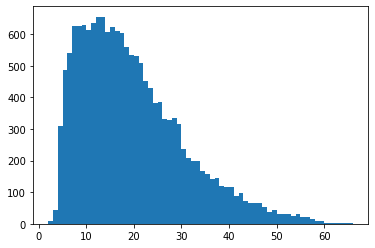

{'sadness', 'surprise', 'joy', 'fear', 'love', 'anger'}


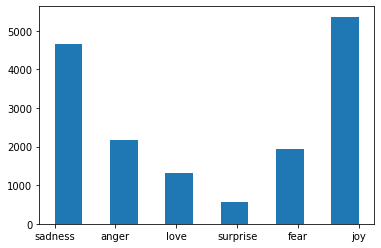

0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 27s 45ms/step - loss: 1.3215 - accuracy: 0.4807 - val_loss: 0.8161 - val_accuracy: 0.6900
Epoch 2/20
500/500 [==============================] - 21s 43ms/step - loss: 0.6283 - accuracy: 0.7749 

In [ ]:
!pip install nlp

%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

#função que plota dos gráficos da emoções, acurácia...

def show_history(h):
    epochs_trained = len(h.history['loss']) #determinando o quanto os valores previstos se desviam dos valores reais nos dados de treinamento
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs') #epochs Indica o número de passagens de todo o conjunto de dados de treinamento que o algoritmo de aprendizado de máquina concluiu 
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    

    #função para matriz de confusão
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__) #mostrando a versão do tf

dataset = nlp.load_dataset('emotion') #baixando o conjunto de dados com as emoções do nlp

dataset

train = dataset['train'] #conjunto de dados de treinamento
val = dataset['validation'] #conjunto de dados de validação
test = dataset['test'] #conjunto de dados de testes

def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels 

tweets, labels = get_tweet(train)

tweets[0], labels[0]


from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>') #oov_token='UNK': isso adicionará um token UNK ao vocabulário.  o índice de UNK é word_count+1.
tokenizer.fit_on_texts(tweets)

tokenizer.texts_to_sequences([tweets[0]])

tweets[0]

lenghts = [len(t.split(' ')) for t in tweets]
plt.hist(lenghts, bins = len(set(lenghts)))
plt.show()

maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

padded_train_seq = get_sequences(tokenizer, tweets)

padded_train_seq[0]

classes = set(labels)
print(classes)

plt.hist(labels, bins=11)
plt.show()

class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

class_to_index

index_to_class

names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

train_labels = names_to_ids(labels)
print(train_labels[0])

maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

model.summary()

#treinamento do modelo

val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

val_tweets[0], val_labels[0]


h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

